# Left/Right stereotypy in Kenyon cells
Here we investigate whether the connections from projection neurons (PNs) to Kenyon
cells (KCs) have a "stereotyped" structure. By stereotyped, we mean whether there is
correlation in the edge structure between multiple samples of this subgraph. Here,
we compare the left and right subgraphs for a single larval *Drosophila* connectome
([Eichler et al. (2017)](https://www.nature.com/articles/nature23455)).

## Introduction
The general thinking in the field is that the connections from PNs to KCs are "random"
(though there are are some caveats and debates, see
[Zheng et al. (2020)](https://www.biorxiv.org/content/10.1101/2020.04.17.047167v2.abstract)).
The word "random" is doing a lot of work here, and I don't think the field would agree
to a distribution on that subgraph-as-a-random-variable that would satisfy us. The
general idea is that the PNs are stereotyped and identifiable across animals: I can
find the same one on each hemisphere of the brain, and across animals. Conversely, the
KCs are not, because there is not thought to be correlation between the edges projecting
from PNs to KCs. See the figure below for a schematic.

```{figure} ./images/mittal-fig-2a.png
---
width: 500px
name: mb-schematic
---
Schematic description of the mushroom body (here shown for the adult *Drosophila*,
the larva has far fewer neurons). Connections from projection neurons (PNs) to
Kenyon cells are thought to be random. Image from
[Mittal et al. (2020)](https://www.nature.com/articles/s41467-020-14836-6).
```

In [1]:

import datetime
import time

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from giskard.plot import histplot, matrixplot
from graspologic.plot import heatmap
from graspologic.simulations import er_corr
from graspologic.utils import binarize
from pkg.data import load_maggot_graph, load_unmatched
from pkg.io import glue as default_glue
from pkg.io import savefig
from pkg.plot import set_theme
from scipy.optimize import linear_sum_assignment
from tqdm import tqdm

DISPLAY_FIGS = True

FILENAME = "kc_stereotypy"


def gluefig(name, fig, **kwargs):
    savefig(name, foldername=FILENAME, **kwargs)

    glue(name, fig, figure=True)

    if not DISPLAY_FIGS:
        plt.close()


def glue(name, var, **kwargs):
    default_glue(name, var, FILENAME, **kwargs)


t0 = time.time()
set_theme()
rng = np.random.default_rng(8888)

left_adj, left_nodes = load_unmatched("left")
right_adj, right_nodes = load_unmatched("right")

mg = load_maggot_graph()

left_mg = mg.node_subgraph(mg[mg.nodes["left"]].nodes.index)
right_mg = mg.node_subgraph(mg[mg.nodes["right"]].nodes.index)

## Data
For this investigation, we select the subgraphs of connections from uniglomerular PNs
to the multi-claw KCs, as these are the specific projections which are thought to be
"unstructured" in their connectivity.

We also remove any KCs which do not recieve a projection from one of these
PNs.

For this analysis, I will consider the subgraphs to be directed and unweighted (though
I discuss the importance of weights going forward at the end).

In [2]:
nodes = left_mg.nodes
upns_left = nodes[nodes["merge_class"] == "uPN"].index
kcs_left = nodes[(nodes["class1"] == "KC") & (nodes["merge_class"] != "KC-1claw")].index

nodes = right_mg.nodes
upns_right = nodes[nodes["merge_class"] == "uPN"].index
kcs_right = nodes[
    (nodes["class1"] == "KC") & (nodes["merge_class"] != "KC-1claw")
].index

In [3]:

n_upns = len(upns_left)


def remove_unconnected_kcs(adj, index, n_upns):
    n_inputs = adj.sum(axis=0)
    keep_mask = ~((n_inputs == 0) & (np.arange(len(n_inputs)) >= n_upns))
    adj = adj[keep_mask][:, keep_mask]
    index = index[keep_mask]
    return adj, index


left_index = np.concatenate((upns_left, kcs_left))
left_mg.nodes = left_mg.nodes.reindex(left_index)
left_subgraph_mg = left_mg.node_subgraph(upns_left, kcs_left)
left_adj = binarize(left_subgraph_mg.sum.adj)

left_adj, left_index = remove_unconnected_kcs(left_adj, left_index, n_upns)
left_labels = np.array(n_upns * ["uPN"] + (len(left_adj) - n_upns) * ["KC"])

right_index = np.concatenate((upns_right, kcs_right))
right_mg.nodes = right_mg.nodes.reindex(right_index)
right_subgraph_mg = right_mg.node_subgraph(upns_right, kcs_right)
right_adj = binarize(right_subgraph_mg.sum.adj)

right_adj, right_index = remove_unconnected_kcs(right_adj, right_index, n_upns)
right_labels = np.array(n_upns * ["uPN"] + (len(right_adj) - n_upns) * ["KC"])

After filtering the data in this way, we have the following numbers of nodes:

In [4]:
print("Number of uPNs (L vs. R):")
print((left_labels == "uPN").sum())
print("vs")
print((right_labels == "uPN").sum())
print()
print("Number of KCs (L vs. R):")
print((left_labels == "KC").sum())
print("vs")
print((right_labels == "KC").sum())

Number of uPNs (L vs. R):
21
vs
21

Number of KCs (L vs. R):
60
vs
59


Below we plot these subgraphs as adjacency matrices - note that there are a lot of
0s because of how we defined the subgraphs.

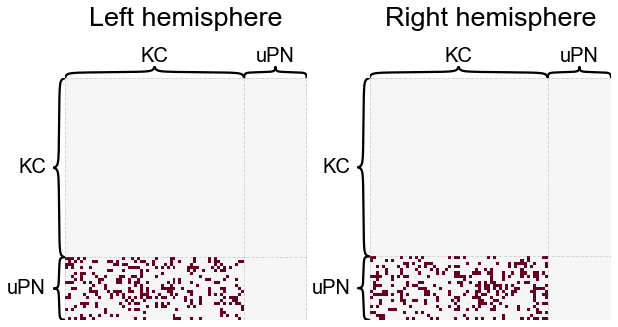

In [5]:
fig, axs = plt.subplots(1, 2, figsize=(10, 5))
heatmap(
    left_adj,
    cbar=False,
    inner_hier_labels=left_labels,
    title="Left hemisphere",
    hier_label_fontsize=20,
    font_scale=1.5,
    ax=axs[0],
)
_ = heatmap(
    right_adj,
    cbar=False,
    inner_hier_labels=right_labels,
    title="Right hemisphere",
    hier_label_fontsize=20,
    font_scale=1.5,
    ax=axs[1],
)
gluefig("left_right_adjs", fig)

## Matching
Now, we try to match the left to the right subgraphs. The identity of the PNs are
known (i.e. we know the pairing for these neurons). Thus, we treat the PNs as seeds,
and try to optimize the permutation of Kenyon cells to minimize edge disagreements.

In [6]:


def get_subgraph(A):
    return A[:n_upns, n_upns:]


def match_seeded_subgraphs(A, B):
    """Assumes A is smaller"""
    assert A.shape[0] == B.shape[0]
    assert A.shape[1] <= B.shape[1]
    product = A.T @ B
    row_inds, col_inds = linear_sum_assignment(product, maximize=True)
    assert (row_inds == np.arange(A.shape[1])).all()
    return col_inds[: A.shape[1]], B[:, col_inds]


def compute_density_subgraph(adjacency):
    n_edges = np.count_nonzero(adjacency)
    n_possible = adjacency.size
    return n_edges / n_possible


def compute_alignment_strength_subgraph(A, B, perm=None):
    n_possible = A.size
    if perm is not None:
        B_perm = B[perm][:, perm]
    else:
        B_perm = B
    n_disagreements = np.count_nonzero(A - B_perm)  # TODO this assumes loopless
    p_disagreements = n_disagreements / n_possible
    densityA = compute_density_subgraph(A)
    densityB = compute_density_subgraph(B)
    denominator = densityA * (1 - densityB) + densityB * (1 - densityA)
    alignment_strength = 1 - p_disagreements / denominator
    return alignment_strength

In [7]:

A_sub = get_subgraph(right_adj)
B_sub = get_subgraph(left_adj)

perm_inds, B_sub_perm = match_seeded_subgraphs(A_sub, B_sub)

Below we plot the PN (rows) to KC (columns) subgraphs under a permutation predicted
by seeded graph matching. We show the left subgraph (top), the right subgraph (middle),
and the difference (left - right) such that any red values indicate an edge on the left
which is not present in the right, and a blue value indicates an edge on the right
which is not in the right.

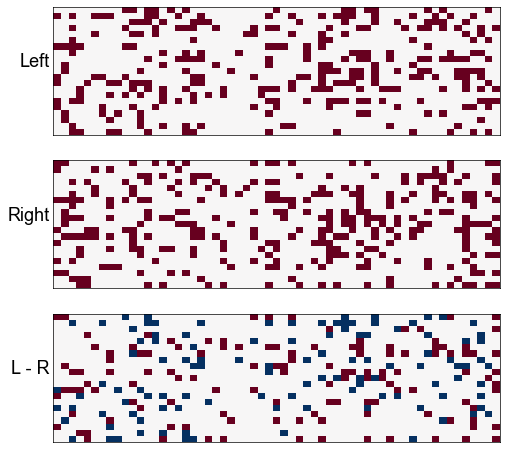

In [8]:

diff = A_sub - B_sub_perm
fig, axs = plt.subplots(3, 1, figsize=(8, 8))

matrixplot(B_sub_perm, cbar=False, ax=axs[0])
matrixplot(A_sub, cbar=False, ax=axs[1])
matrixplot(diff, cbar=False, ax=axs[2])

# axs[0].set_title("KCs (graph matched)")
axs[0].set_ylabel("Left", rotation=0, ha="right")
axs[1].set_ylabel("Right", rotation=0, ha="right")
axs[2].set_ylabel("L - R", rotation=0, ha="right")

fig.set_facecolor("w")

gluefig("matched_subgraphs", fig)

We also compute a metric to measure the degree of overlap between the matched
subgraphs. This metric is called alignment strength, defined in
[Fishkind et al. (2021)](https://link.springer.com/article/10.1007/s41109-021-00398-z).
it measures the amount of edge disagreements relative to what one would expect by
chance under a *random* matching.

In [9]:
observed_alignment = compute_alignment_strength_subgraph(A_sub, B_sub_perm)

glue("observed_alignment", observed_alignment)

We find that for the optimized matching, the alignment strength is
{glue:text}`kc_stereotypy-observed_alignment:.2f`. But what should we make of this?
Two random subgraphs would also have some degree of alignment between their edges
under an optimized matching.

## Comparing our edge disagreements to a null model

To calibrate our expectations for the alignment strength, we compute the alignment
strength for a series of network pairs sampled from a null model. In other words, we
sample two networks *which share no edge correlation*, match them, and compute the
alignment strength. This gives us a distribution of alignment strengths to compare
to.

In [10]:

n_sims = 1000
glue("n_sims", n_sims)


def er_subgraph(size, p, rng=None):
    subgraph = rng.binomial(1, p, size=size)
    return subgraph


p_A = np.count_nonzero(A_sub) / A_sub.size
p_B = np.count_nonzero(B_sub) / B_sub.size

rows = []
for sim in tqdm(range(n_sims), leave=False):
    A_sim = er_subgraph(A_sub.shape, p_A, rng)
    B_sim = er_subgraph(B_sub.shape, p_B, rng)

    perm_inds, B_sim_perm = match_seeded_subgraphs(A_sim, B_sim)

    alignment = compute_alignment_strength_subgraph(A_sim, B_sim_perm)

    rows.append({"data": "ER", "alignment": alignment})

rows.append({"data": "Observed", "alignment": observed_alignment})

results = pd.DataFrame(rows)

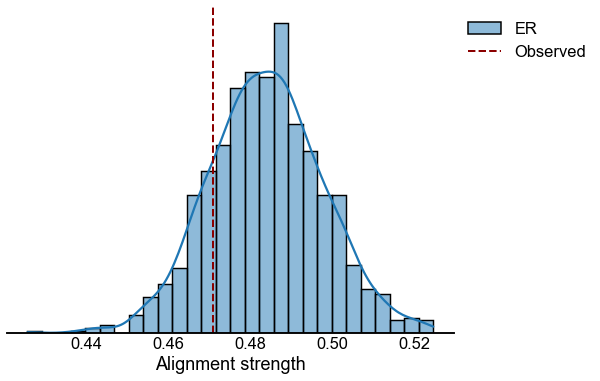

In [11]:

fig, ax = plt.subplots(1, 1, figsize=(8, 6))
histplot(data=results, x="alignment", hue="data", kde=True, ax=ax)
ax.set(ylabel="", yticks=[], xlabel="Alignment strength")
ax.spines["left"].set_visible(False)

gluefig("alignment_dist", fig)

## Questions/thoughts
```{admonition} Note
:class: note
**Am I matching correctly for a pair of bipartite networks where one "part" is
completely seeded?**

In this case, the graph matching minimization problem reduces to to solving a linear
assignment problem to do

$$
\min_P tr(P^T A_{12}^T B_{12})
$$

where $A_{12}$ is the subgraph of connections from seeded (PN) to nonseeded (KC) on
one hemisphere, and $B_{12}$ is defined likewise for the other hemisphere. This is
because $A_{11}, A_{21}$ and $A_{22}$ (and likewise for $B$) are all 0 due to how
we've defined our subgraphs.

```

```{admonition} Question
:class: tip
**How exactly should I compute alignment strength here?**
There are a couple of weirdnesses:
- we have bipartite networks,
- In the phantom alignment strength paper, it is suggested (I think) to only look at
  the restricted alignment strength which considers the unseeded-to-unseeded subgraph.
  But in our case, that subgraph is empty.
```

```{admonition} Question
:class: tip
**How to deal with weights for the null model?**
```

```{admonition} Question
:class: tip
**How to deal with weights for the alignment strength test statistic?**
```

```{admonition} Question
:class: tip
**How to deal with an unequal number of Kenyon cells?**
```

## Appendix
### Testing alignment strength implementation

In [12]:
# Seeded, bipartite alignment strength.

n = 20
p = 0.23
n_sims = 1_000
rows = []
for rho in [0.3, 0.8]:
    for permute in [True, False]:
        for i in tqdm(range(n_sims), leave=False):
            A1, B1 = er_corr(n, p, rho, loops=False, directed=True)
            A2, B2 = er_corr(n, p, rho, loops=False, directed=True)
            A3, B3 = er_corr(n, p, rho, loops=False, directed=True)
            A = np.hstack((A1, A2, A3))
            B = np.hstack((B1, B2, B3))
            if permute:
                permutation = np.random.permutation(B.shape[1])
                B = B[:, permutation]
            alignment = compute_alignment_strength_subgraph(A, B)
            rows.append({"permute": permute, "alignment": alignment, "rho": rho})

results = pd.DataFrame(rows)

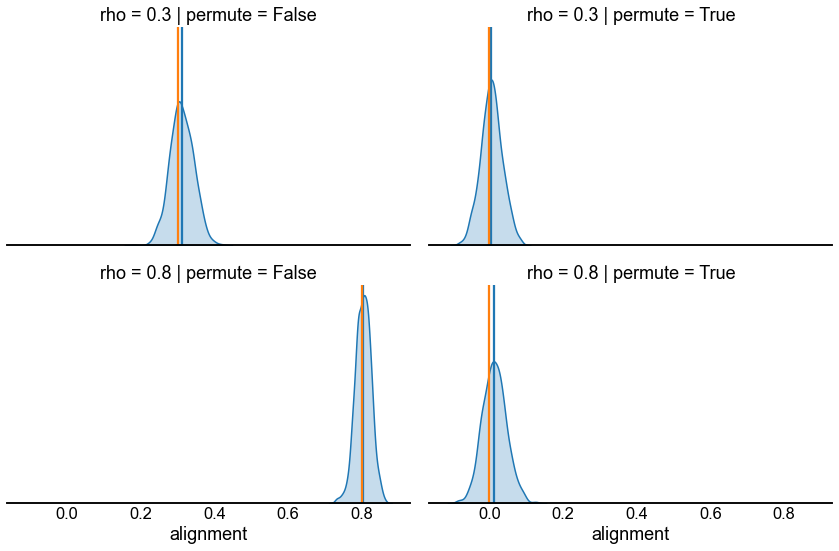

In [13]:

fg = sns.FacetGrid(data=results, row="rho", col="permute", height=4, aspect=1.5)
fg.map(sns.kdeplot, "alignment", fill=True)


def meanline(x, *args, **kwargs):
    ax = plt.gca()
    ax.axvline(x.mean(), color="tab:blue")
    ax.spines["left"].set_visible(False)
    ax.set(ylabel="", yticks=[])


fg.map(meanline, "alignment")
fg.axes[0, 0].axvline(0.3, color="tab:orange")
fg.axes[0, 1].axvline(0.0, color="tab:orange")
fg.axes[1, 0].axvline(0.8, color="tab:orange")
_ = fg.axes[1, 1].axvline(0.0, color="tab:orange")

## End

In [14]:
elapsed = time.time() - t0
delta = datetime.timedelta(seconds=elapsed)
print(f"Script took {delta}")
print(f"Completed at {datetime.datetime.now()}")

Script took 0:00:21.051601
Completed at 2022-05-11 11:42:00.272450
